In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# Install Keras and cv2 to Google Engine
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

!pip install keras

In [0]:
###############################################################################
# Libraries import
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import cv2

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from keras import backend as K
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

K.set_image_dim_ordering('th')

###############################################################################


In [0]:
# Give a name to id the data used in this training
# use the name of validation driver

# These are the validation divisions created from driver ids:

valid_ids= [['p066', 'p021', 'p024'],
 ['p026', 'p072', 'p015'],
 ['p052', 'p061', 'p042', 'p081'],
 ['p016', 'p041', 'p050'],
 ['p047', 'p064', 'p035'],
 ['p049', 'p002', 'p012', 'p039'],
 ['p056', 'p051', 'p022'],
 ['p075', 'p014', 'p045']]


# Select the validation id group to use for this particular training

i=7
print(valid_ids[i])


# generate file name to identify the valid ids group used

if len(valid_ids[i]) == 3:
  train_data_filename = str(valid_ids[i][0] + "_" + valid_ids[i][1] + "_" +
                         valid_ids[i][2] + "_1_96_128")
else:
  train_data_filename = str(valid_ids[i][0] + "_" + valid_ids[i][1] + "_" +
                          valid_ids[i][2] + "_" + valid_ids[i][3] + "_1_96_128")
    

print(train_data_filename)

# generate location address for train data
train_file_address =  str("drive/Colab_Notebooks/x_train_" + train_data_filename + ".pk1")
train_file_address2 =  str("drive/Colab_Notebooks/y_train_xy_valid_" + train_data_filename + ".pk1")

print(train_file_address)
print(train_file_address2)


# Create a validation prediction file for dashboard and other visualization 
# Read the original drivers_img_list for validation drivers only
# Short by validation driver in this particular dataset


# Read the full drivers list
train_driver_list = pd.read_csv('drive/Colab_Notebooks/Data/driver_imgs_list.csv')

# filter out only drivers from the validation set
valid_df =train_driver_list.loc[train_driver_list['subject'].isin(valid_ids[i])]



In [0]:
# Import and read data fromm pickle sets
import pickle
with open (train_file_address, 'rb') as f:
    x_train = pickle.load(f)
       
with open (train_file_address2, 'rb') as f:
    y_train = pickle.load(f)
    x_valid = pickle.load(f)
    y_valid = pickle.load(f)


In [0]:
# Verify the shape of data
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

In [0]:
# Define some image and class parameters
# color type: 1 = grey, 3 = rgb
color_type = 1
img_rows, img_cols = 96, 128
nb_classes = 10  # 2 for "imgs_sub2"; 10 for others

   
##############################################################################

In [0]:
# reshape images for the convolution layers
x_train = x_train.reshape(x_train.shape[0], color_type, img_rows, img_cols )
x_valid = x_valid.reshape(x_valid.shape[0], color_type, img_rows, img_cols )

In [0]:
###############################################################################
# Image augmentation steps    


datagen = ImageDataGenerator(
       rotation_range=0.2, height_shift_range=0.05, shear_range=0.75, channel_shift_range=0.00001, width_shift_range=0.1)

datagen.fit(x_train)

 
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(img_rows, img_cols), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break


###############################################################################


In [0]:
# Set model batch size and epoch parameters.
batch_size =500
nb_epoch =100

# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 3
# convolution kernel size
nb_conv = 3

In [0]:
# create a convolution model with keras

from keras.optimizers import SGD, Adam, Adadelta, Adamax

# Key to select if using as-is data(transposed, resize, grey scale) Or
# if using augmented data.  (0 for as-is, 1 for augmented)

augm_data = 1

print(batch_size)

activation = 'relu'


# read saved model, if any
model_from_cache = 0
if model_from_cache == 1:
    model = read_model()
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
else:
    model = Sequential()
    model.add(BatchNormalization(axis=1, input_shape=(color_type, img_rows, img_cols)))
    # first convolution layer
    model.add(Convolution2D(nb_filters, (nb_conv, nb_conv),
                            padding="same",
                            input_shape=(1,img_rows, img_cols), data_format = 'channels_first'))
    model.add(Activation(activation))
    #model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))
    
    # 2nd cn layer
    model.add(Convolution2D((nb_filters), (nb_conv, nb_conv)))
    model.add(Activation(activation))
    # max pooling and dropout
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D((2*nb_filters), (nb_conv, nb_conv)))
    model.add(Activation(activation))
    #max pooling and dropout
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.3))
    
    model.add(Convolution2D((3*nb_filters), (nb_conv, nb_conv)))
    model.add(Activation(activation))
    #max pooling and dropout
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.4))
    
    #model.add(Convolution2D((nb_filters*4), (nb_conv, nb_conv)))
    #model.add(Activation(activation))
    # max pooling and dropout
    #model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    #model.add(Dropout(0.4))
    
  
    # flatten and dropout layers
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Activation(activation))
    model.add(Dropout(0.4))
    
    model.add(Dense(128))
    model.add(Activation(activation))
    model.add(Dropout(0.3))
    
    # fully connected layer with softmax for probablities
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.summary()
    
    adadel = Adadelta(lr=0.99, rho=0.95, epsilon=None, decay=0.0)
    
    
    # compile and train model
    model.compile(loss='categorical_crossentropy', optimizer= 'adadelta', metrics=['accuracy'])

    if augm_data ==  0:
        # For Non-augmented data
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epoch,
                  verbose=1, validation_data=(x_valid, y_valid))
    else:
    # for augmented data
        history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                            epochs=nb_epoch,
                            verbose=1, steps_per_epoch=len(x_train)/batch_size, 
                            validation_data=(x_valid, y_valid))

model.summary()  # get model summary
 
###############################################################################





train score:  [0.03472377785503156, 0.9902048975512244]
valid score:  [0.6403527435013273, 0.7688483844241922]


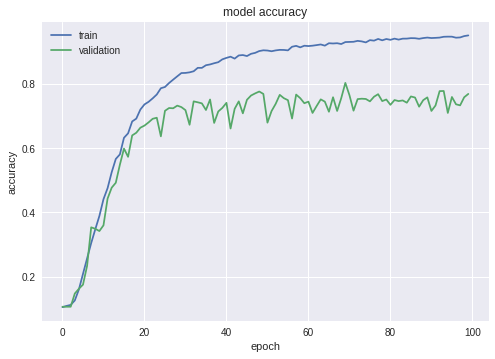

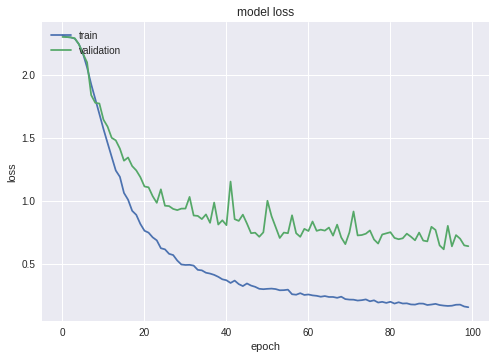

In [81]:
# Score model on train and validation sets.
# Save training log with train and validation metrics in a dataframe
# plot training history.
train_score = model.evaluate(x_train, y_train, verbose=0)
print('train score: ', train_score)

valid_score = model.evaluate(x_valid, y_valid, verbose=0)
print('valid score: ', valid_score)

train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']



results_df = pd.DataFrame(
    {'train_loss': train_loss,
     'train_acc': train_acc,
     'val_loss': val_loss,
     'val_acc': val_acc
    })





# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
# Print some of the results for viewing
#print(results_df)
print(results_df[:11])
print(results_df[90:100])

In [0]:
# Name the model type to id weights and results
Model_type =  "complex_conv"

In [84]:
# Save weights if model is acceptable

# serialize weights to HDF5
weights_filename = 'drive/Colab_Notebooks/Models/' + Model_type + "_" + train_data_filename + '_weights.h5'
print(str(weights_filename))
model.save_weights(weights_filename)

#model.save_weights(str(train_data_filename +".h5"))
#print("Saved model to disk")

drive/Colab_Notebooks/Models/complex_conv_p075_p014_p045_1_96_128_weights.h5


In [85]:
# Save the training results file
results_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_results.csv'
print(results_filename)
results_df.to_csv(results_filename, sep=',')

drive/Colab_Notebooks/Results/complex_conv_p075_p014_p045_1_96_128_results.csv


In [0]:
# function to plot images in proper order
from skimage.transform import rotate
def show_image(image):
    img = image.squeeze()
    plt.axis("off")
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(np.fliplr(rotate(img, 270)), cmap='gray', interpolation='nearest')  
    # Manipulation to display image in the correct orientation!
    plt.show() 
    #print image.shape
    #plt.imshow(image)

In [0]:
# function to convert probs to class
from skimage.transform import rotate

def predictions_results(prediction_probs):
    results = []
    for pred in prediction_probs:
        idx = np.argmax(pred)
        result = np.zeros(len(pred))
        result[idx] = 1
        results.append(result)
    return results



In [0]:
# predict on train set just to verify accuracy
train_predict_probs = model.predict(x_train, batch_size = batch_size, verbose = 1)

# convert prediction probabilities to class array for train set
y_train_predicted= predictions_results(train_predict_probs)


# convert the true and predicted array into classes

# For train data 

train_true_classes = np.argmax(y_train,  axis=1)
train_pred_classes = np.argmax(y_train_predicted,  axis=1)


# View some actual and predicted examples train set
for num in np.random.choice(len(y_train),2, replace = False):
    show_image(x_train[num])
    print("y_train true array:", y_train[num])
    print("y_train true class: c" + str(train_true_classes[num]))
    print("y_train predicted array:", y_train_predicted[num])
    print("y_train predicted class: c" + str(train_pred_classes[num]))

In [0]:
# Verify predictions for validation set
# collect predictions on valid set
# Store probs in a dataframe and csv for later use
valid_prediction_probs = model.predict(x_valid, batch_size = batch_size, verbose = 1)
print(valid_prediction_probs[1])

valid_probs_df= pd.DataFrame(valid_prediction_probs)
print(valid_probs_df[1:5])
valid_probs_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_valid_probs.csv'
valid_probs_df.to_csv(valid_probs_filename, sep=',')


# convert prediction probabilities to class array for validation set
y_valid_predicted= predictions_results(valid_prediction_probs)
#print(y_valid_predicted[1])


# convert the true and predicted array into classes
# for validation set

valid_true_classes = np.argmax(y_valid,  axis=1)
valid_pred_classes = np.argmax(y_valid_predicted,  axis=1)


# View some actual and predicted examples validation set
for num in np.random.choice(len(y_valid), 2, replace = False):
    show_image(x_valid[num])
    print("y_valid true array:", y_valid[num])
    print("y_valid true class: c" + str(valid_true_classes[num]))
    print("y_valid predicted array:", y_valid_predicted[num])
    print("y_valid predicted class: c" + str(valid_pred_classes[num]))


###############################################################################

In [0]:


# Add the validation predictions to valid_driver_list
# Add the true classes for now to ensure that the order of valid_driver_list and predictions is same.
#valid_df= pd.DataFrame()
valid_df['true'] = valid_true_classes
valid_df['pred'] = valid_pred_classes
valid_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_valid.csv'
print(valid_filename)
print(valid_df.head(n=5))
valid_df.to_csv(valid_filename, sep=',')


Confusion matrix, without normalization
[[2202    3    1    5    1    3    0    0    8   10]
 [   1 2007    0    0    0    0    0    0    0    0]
 [   0    0 2052    0    0    0    3    0    1    0]
 [   4    0    0 2086    2    0    0    0    0    0]
 [   0    3    0    3 2052    0    0    0    1    0]
 [  10    0    0    0    0 2044    0    0    0    1]
 [   0    7    2    0    0    1 2053    0    6    2]
 [   0    2    3    0    0    1    0 1769    1    0]
 [   9    5   26    0    1    1   10    1 1648   27]
 [  18    5    1    0    0    2    1    0    4 1901]]
Normalized confusion matrix
[[9.86e-01 1.34e-03 4.48e-04 2.24e-03 4.48e-04 1.34e-03 0.00e+00 0.00e+00
  3.58e-03 4.48e-03]
 [4.98e-04 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 9.98e-01 0.00e+00 0.00e+00 0.00e+00 1.46e-03 0.00e+00
  4.86e-04 0.00e+00]
 [1.91e-03 0.00e+00 0.00e+00 9.97e-01 9.56e-04 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00]
 [0.00e+00 1.46e-03 0

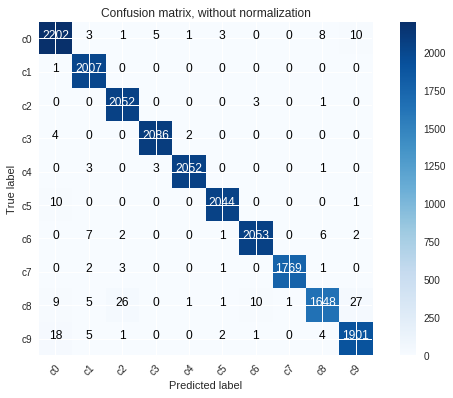

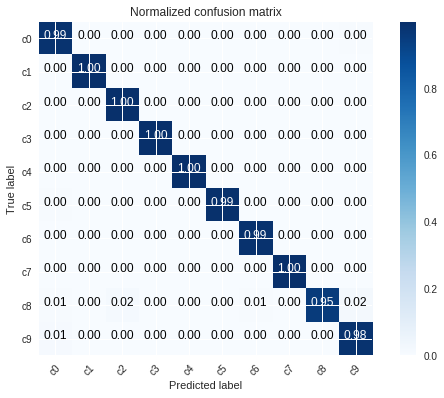

Confusion matrix, without normalization
[[163   0   0   4  16   7   0   0   0  66]
 [  0 248   5   0   0   0   0   6   0   0]
 [  0   1 257   0   0   0   0   1   2   0]
 [ 10  20   1 183  20   5   0   0   0  15]
 [  0   1   1   1 244   6   0   1   2  11]
 [  4   2   1   0   0 186   0   0   0  64]
 [  0   9   0   0   0   0 179   0  66   0]
 [  1   9   0   1   3   4   0 152  29  27]
 [ 20   0   0   1   4   4   0   4 142   8]
 [ 18   0  30   0   0  21   0  24   2 102]]
Normalized confusion matrix
[[0.64 0.   0.   0.02 0.06 0.03 0.   0.   0.   0.26]
 [0.   0.96 0.02 0.   0.   0.   0.   0.02 0.   0.  ]
 [0.   0.   0.98 0.   0.   0.   0.   0.   0.01 0.  ]
 [0.04 0.08 0.   0.72 0.08 0.02 0.   0.   0.   0.06]
 [0.   0.   0.   0.   0.91 0.02 0.   0.   0.01 0.04]
 [0.02 0.01 0.   0.   0.   0.72 0.   0.   0.   0.25]
 [0.   0.04 0.   0.   0.   0.   0.7  0.   0.26 0.  ]
 [0.   0.04 0.   0.   0.01 0.02 0.   0.67 0.13 0.12]
 [0.11 0.   0.   0.01 0.02 0.02 0.   0.02 0.78 0.04]
 [0.09 0.   0.15 0.   0.

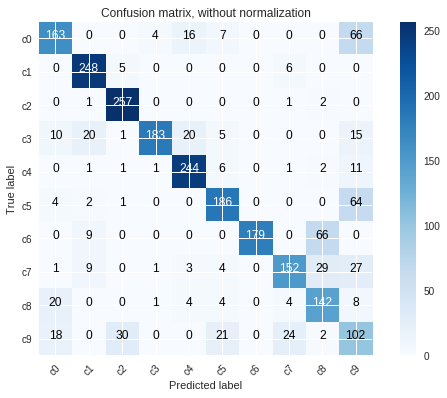

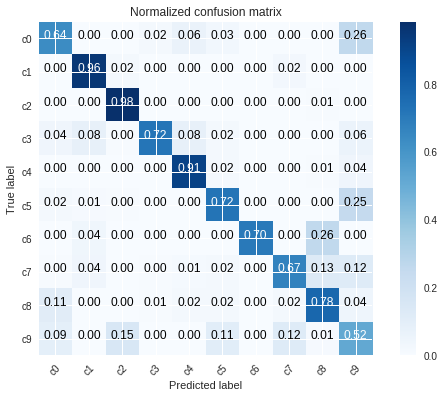

In [91]:
# Results visualization

# Confusion Matrix

class_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
class_names2 = ['c0', 'c1']


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
    
# Train data
cnf_matrix = confusion_matrix(train_true_classes, train_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


# Valid data

cnf_matrix = confusion_matrix(valid_true_classes, valid_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

###############################################################################

In [52]:
# Metrics

from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(valid_true_classes, valid_pred_classes, average='weighted')


from sklearn.metrics import classification_report
print(classification_report(valid_true_classes, valid_pred_classes, target_names=class_names))


             precision    recall  f1-score   support

         c0       0.69      0.49      0.57       309
         c1       0.86      0.72      0.79       317
         c2       0.98      0.79      0.88       366
         c3       0.97      0.97      0.97       343
         c4       0.92      0.93      0.92       352
         c5       0.80      0.51      0.62       352
         c6       0.63      0.93      0.75       340
         c7       0.69      0.97      0.81       282
         c8       0.65      0.71      0.68       255
         c9       0.55      0.62      0.58       294

avg / total       0.79      0.77      0.76      3210



In [0]:
# compare predicts with actual and count correct and incorrect classificaitons
correct_class = []
wrong_class = []
c = 0

for yc, yp in zip(valid_true_classes, valid_pred_classes):
    if yc == yp:
        #print "correct_class: Class {}, {} predicted".format(np.argmax(yclass), np.argmax(ypredict))
        correct_class.append([c, yp])
    else:
        #print "wrong_class!: Class {}, {} predicted".format(np.argmax(yclass), np.argmax(ypredict))
        wrong_class.append([c, yp])
    c += 1
    
print("correct_classfully validated {} / {} = {}%".format(len(correct_class), c, (float(len(correct_class))/float(c))*100))
#print "correct_class: {}".format(correct_class)
#print "wrong_class: {}".format(wrong_class)

# Create labels to assign to predictions and plot examples
# labels for org data (use for full data or sub1)
labels_org = [  'c0: safe driving',
            'c1: texting - right',
            'c2: talking on the phone - right',
            'c3: texting - left',
            'c4: talking on the phone - left',
            'c5: operating the radio',
            'c6: drinking',
            'c7: reaching behind',
            'c8: hair and makeup',
            'c9: talking to passenger']

# labels for two category sub2 data
labels_sub2 = [  'c0: safe driving',
            'c1: distracted driving']

# set correct labels
labels=labels_org

    
#print correct_class examples

print("Sample of images validated correctly:")
for s in np.random.choice(len(correct_class), 5, replace = False):
    print("***************\nRendering image {}".format(s))
    image = x_valid[correct_class[s][0]]
    show_image(image)
    print("Classified correctly as {}\n".format(labels[np.argmax(y_valid_predicted[correct_class[s][0]])]))
    
    
# print wrong classification examples    
print("Sample of images validated incorrectly:")
for s in np.random.choice(len(wrong_class), 5, replace = False):
    print("***************\nRendering image {}".format(s))
    image = x_valid[wrong_class[s][0]]
    show_image(image)
    print("Classified incorrectly as {}\n".format(labels[np.argmax(y_valid_predicted[wrong_class[s][0]])]))
    

